In [1]:
pip install --ignore-installed --upgrade tensorflow==1.14

  Using cached https://files.pythonhosted.org/packages/f7/08/25e47a53692c2e0dcd2211a493ddfe9007a5cd92e175d6dffa6169a0b392/tensorflow-1.14.0-cp37-cp37m-win_amd64.whl
  Using cached https://files.pythonhosted.org/packages/71/e3/19762fdfc62877ae9102edf6342d71b28fbfd9dea3d2f96a882ce099b03f/Keras_Applications-1.0.8-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/8a/48/a76be51647d0eb9f10e2a4511bf3ffb8cc1e6b14e9e4fab46173aa79f981/termcolor-1.1.0.tar.gz
  Using cached https://files.pythonhosted.org/packages/3c/d5/21860a5b11caf0678fbc8319341b0ae21a07156911132e0e71bffed0510d/tensorflow_estimator-1.14.0-py2.py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/91/2d/2ed263449a078cd9c8a9ba50ebd50123adf1f8cfbea1492f9084169b89d9/tensorboard-1.14.0-py3-none-any.whl
  Using cached https://files.pythonhosted.org/packages/28/6a/8c1f62c37212d9fc441a7e26736df51ce6f0e38455816445471f10da4f0a/Keras_Preprocessing-1.1.0-py2.py3-none-any.whl
  Stored in directory: C:\Us

# Image captioning
![](rename.gif)
- Generating caption for images

## Steps
- Data collection
- Understanding the data
- data cleaning 
- loading the training set
- Data preprocessing - Images 
- Data preprocessing - Captions
- Data preperation using generator function
- Word Embeddings
- Model Architecture
- Interface
- Evaluation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers.merge import add
import cv2

Using TensorFlow backend.
C:\Users\sahib\Anaconda3\envs\tf-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\sahib\Anaconda3\envs\tf-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\sahib\Anaconda3\envs\tf-GPU\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\sahib\Anaconda3\envs\tf-GPU\lib\sit

In [3]:
# Read Text Captions

def readTextFile(path):
    with open(path) as f:
        captions = f.read()
    return captions

In [9]:
captions  = readTextFile("D:/datasets/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt")
captions = captions.split('\n')[:-1]
 

In [15]:

print(len(captions))
print(captions[-1])
print(captions[1].split('\t') )

40460
997722733_0cb5439472.jpg#4	A rock climber practices on a rock climbing wall .
['1000268201_693b08cb0e.jpg#1', 'A girl going into a wooden building .']


In [17]:

first,second  = captions[1].split('\t') #splits entire caption 
print(first.split(".")[0]) # splits the image into 2 parts 
print(second)

1000268201_693b08cb0e
A girl going into a wooden building .


In [31]:
descriptions = {}
# Dictionary to Map each Image with the list of captions it has

for x in captions:
    first,second = x.split('\t')
    img_name = first.split(".")[0]
    
    #if the image id is already present or not
    if descriptions.get(img_name) is None:
        descriptions[img_name] = []
    
    descriptions[img_name].append(second)


In [32]:
descriptions["1000268201_693b08cb0e"]

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

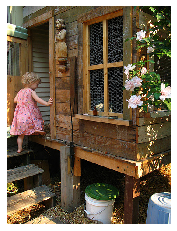

In [33]:
IMG_PATH = "D:/datasets/Flickr_Data/Flickr_Data/Images/"
img = cv2.imread(IMG_PATH +"1000268201_693b08cb0e.jpg" )
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
plt.imshow(img)
plt.axis("off")
plt.show()

## Datacleaning

In [34]:
def clean_text(sentence):
    sentence = sentence.lower()  #coverting each letter to lower
    sentence = re.sub("[^a-z]+"," ",sentence) #using regular exp. to remove no from sentance
    sentence = sentence.split() #split all the words 
    
    sentence  = [s for s in sentence if len(s)>1] #removing all the word whose length is less then 1
    sentence = " ".join(sentence) #joining all the words 
    return sentence

In [35]:
clean_text("i saw a dog in house #$453")

'saw dog in house'

In [36]:

# Clean all Captions
for key,caption_list in descriptions.items():
    for i in range(len(caption_list)):
        caption_list[i] = clean_text(caption_list[i])

In [37]:
descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [38]:
# Write the data to text file
with open("descriptions.txt","w") as f:
    f.write(str(descriptions))

##  Creating Vocabulary

In [39]:
#loading the description file which we saved above
descriptions = None
with open("descriptions.txt",'r') as f:
    descriptions= f.read()
    
json_acceptable_string = descriptions.replace("'","\"") #replacing all the " ' " with \ to make json acceptable
descriptions = json.loads(json_acceptable_string)

In [40]:
descriptions['1000268201_693b08cb0e']


['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

In [41]:
#creating vocabulary
vocab = set()
for keys in descriptions.keys():
    [vocab.update(sentence.split()) for sentence in descriptions[keys]] #iterating aver all the words in captions
print("Vocabulary size %d"%len(vocab))

Vocabulary size 8424


In [42]:
total_words = []

for key in descriptions.keys():
    [total_words.append(i) for des in descriptions[key] for i in des.split()]
    
print("Total Words %d"%len(total_words))

Total Words 373837


In [43]:
#filtering words from vocabulary according to certain thresold

In [44]:
import collections
Wcounter = collections.Counter(total_words)
freq_count = dict(Wcounter)


In [45]:
len(freq_count.keys())

8424

In [46]:
# Sort this dictionary according to the freq count
sorted_freq_cnt = sorted(freq_count.items(),reverse=True,key=lambda x:x[1])

# Filter
threshold = 10
sorted_freq_cnt  = [x for x in sorted_freq_cnt if x[1]>threshold]
total_words = [x[0] for x in sorted_freq_cnt]

In [47]:
print(len(total_words))

1845


## Preparing Train & Test data

In [48]:
train_file_data = readTextFile("D:/datasets/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt")
test_file_data = readTextFile("D:/datasets/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt")

In [49]:
#using list comprehension to get all the train data into a single string
train = [row.split(".")[0] for row in train_file_data.split("\n")[:-1]]
test = [row.split(".")[0] for row in test_file_data.split("\n")[:-1]]
#splitting row from a "." and extracting 0th elelemt of the split which is images name

In [50]:
print(test[:5])

['3385593926_d3e9c21170', '2677656448_6b7e7702af', '311146855_0b65fdb169', '1258913059_07c613f7ff', '241347760_d44c8d3a01']


In [51]:
# preparing descriptions for training data 
# tweak - adding <s>(for starting) and <e>(for ending)
# because our model is recursive so it will going to add words in sentence the model should know where
# to start and end to fix this <s> <e> will going to tell where to start and end sentence  

In [52]:
train_description = {}
for img_ids in train:
    train_description[img_ids] = []
    for captions in descriptions[img_ids]:
        capt_to_append = "start_seq " + captions + " end_seq"
        train_description[img_ids].append(capt_to_append)

In [53]:
train_description['1000268201_693b08cb0e']

['start_seq child in pink dress is climbing up set of stairs in an entry way end_seq',
 'start_seq girl going into wooden building end_seq',
 'start_seq little girl climbing into wooden playhouse end_seq',
 'start_seq little girl climbing the stairs to her playhouse end_seq',
 'start_seq little girl in pink dress going into wooden cabin end_seq']

### Transfer Learning 
- Images --> features
- Text --> features

## Step1 image features Extractions

In [54]:
model = ResNet50(weights = "imagenet",input_shape = (224,224,3))
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
activation

In [55]:
new_model = Model(model.input,model.layers[-2].output)

In [56]:
def preprocess_images(img):
    img = image.load_img(img,target_size=(224,224))
    img = image.img_to_array(img)
    #img = img.reshape(1,224,224,3)
    img = np.expand_dims(img,axis=0)
    # Normalisation
    img = preprocess_input(img)
    return(img)

In [57]:
def encode_image(img):
    img = preprocess_images(img) #calling preprocess_imgs to preprocess our img
    feature_vector = new_model.predict(img) #getting features from model
    
    feature_vector = feature_vector.reshape((-1,))
    #print(feature_vector.shape)
    return feature_vector

In [58]:
print(IMG_PATH)
encode_image(IMG_PATH +"2513260012_03d33305cf.jpg")

D:/datasets/Flickr_Data/Flickr_Data/Images/


array([0.28047323, 0.40687522, 0.0837999 , ..., 0.9107925 , 0.04341797,
       0.09577909], dtype=float32)

In [173]:

start = time() #to measure time
encoding_train = {} 
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(train):
    img_path = IMG_PATH + img_id +".jpg"
    encoding_train[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken :",end_t-start)

Encoding in Progress Time step 0 
Encoding in Progress Time step 100 
Encoding in Progress Time step 200 
Encoding in Progress Time step 300 
Encoding in Progress Time step 400 
Encoding in Progress Time step 500 
Encoding in Progress Time step 600 
Encoding in Progress Time step 700 
Encoding in Progress Time step 800 
Encoding in Progress Time step 900 
Encoding in Progress Time step 1000 
Encoding in Progress Time step 1100 
Encoding in Progress Time step 1200 
Encoding in Progress Time step 1300 
Encoding in Progress Time step 1400 
Encoding in Progress Time step 1500 
Encoding in Progress Time step 1600 
Encoding in Progress Time step 1700 
Encoding in Progress Time step 1800 
Encoding in Progress Time step 1900 
Encoding in Progress Time step 2000 
Encoding in Progress Time step 2100 
Encoding in Progress Time step 2200 
Encoding in Progress Time step 2300 
Encoding in Progress Time step 2400 
Encoding in Progress Time step 2500 
Encoding in Progress Time step 2600 
Encoding in P

In [177]:
# Store everything to the disk 
with open("../image captionate project/encoded_train_features.pkl","wb") as f:
    pickle.dump(encoding_train,f)

In [60]:
start = time()
encoding_test = {}
#image_id -->feature_vector extracted from Resnet Image

for ix,img_id in enumerate(test):
    img_path = IMG_PATH+"/"+img_id+".jpg"
    encoding_test[img_id] = encode_image(img_path)
    
    if ix%100==0:
        print("Test Encoding in Progress Time step %d "%ix)
        
end_t = time()
print("Total Time Taken(test) :",end_t-start)

Test Encoding in Progress Time step 0 
Test Encoding in Progress Time step 100 
Test Encoding in Progress Time step 200 
Test Encoding in Progress Time step 300 
Test Encoding in Progress Time step 400 
Test Encoding in Progress Time step 500 
Test Encoding in Progress Time step 600 
Test Encoding in Progress Time step 700 
Test Encoding in Progress Time step 800 
Test Encoding in Progress Time step 900 
Total Time Taken(test) : 89.43860507011414


In [61]:
with open("../image captionate project/encoded_test_features.pkl","wb") as f:
    pickle.dump(encoding_test,f)

In [62]:
with open("../image captionate project/encoded_test_features.pkl","rb") as f:
    encoding_test = pickle.load(f)

In [63]:
with open("../image captionate project/encoded_train_features.pkl","rb") as f:
    encoding_train = pickle.load(f)

In [64]:
len(encoding_train)

6000

## Data preprocessing for captions

In [65]:
#vocab
len(total_words)

1845

In [66]:
word_to_idx = {}
idx_to_word = {}
for i, word in enumerate(total_words):
    word_to_idx[word] = i+1
    idx_to_word[i+1] = word

In [67]:
print(word_to_idx['see'])
print(idx_to_word[1000])

1094
helps


In [68]:
# adding start_seq and end_seq to our vocab
word_to_idx['start_seq'] = 1846
idx_to_word[1846] = 'start_seq'

word_to_idx['end_seq'] = 1847
idx_to_word[1847] = 'end_seq'

vocab_size = len(word_to_idx) +1
print("vocab size is",vocab_size)


vocab size is 1848


In [69]:
max_len = 0 
for keys in train_description.keys(): #key will get image name
    for cap in train_description[keys]: # cap will be caption found from key
        max_len = max(max_len,len(cap.split())) #splitting each caption to word and selecting max len sentance
print(max_len)

35


## data generator(data loader)

In [44]:

def data_generator(train_descriptions,encoding_train,word_to_idx,max_len,batch_size):
    X1,X2, y = [],[],[]
    
    n =0
    while True:
        for key,desc_list in train_descriptions.items():
            n += 1
            
            photo = encoding_train[key]
            for desc in desc_list:
                
                seq = [word_to_idx[word] for word in desc.split() if word in word_to_idx]
                for i in range(1,len(seq)):
                    xi = seq[0:i]
                    yi = seq[i]
                    
                    #0 denote padding word
                    xi = pad_sequences([xi],maxlen=max_len,value=0,padding='post')[0]
                    yi = to_categorical([yi],num_classes=vocab_size)[0]
                    
                    X1.append(photo)
                    X2.append(xi)
                    y.append(yi)
                    
                if n==batch_size:
                    yield [[np.array(X1),np.array(X2)],np.array(y)]
                    X1,X2,y = [],[],[]
                    n = 0

## Word embeddings

In [84]:
f = open("D:/datasets/glove.6B.50d.txt",encoding='utf8')

In [85]:
embedding_index = {}
for line in f:
    values = line.split()
    word = values[0]
    embedding_word = np.array(values[1:],dtype = 'float')
    embedding_index[word] = embedding_word
    

In [86]:
f.close()

In [87]:
print(embedding_index['sahib']) #representing each word with 50 nos

[ 0.89076   -0.63184   -0.037906  -0.1458     1.5133    -0.80394
  0.72308    0.14102   -0.25044   -0.51763   -0.1604    -0.46217
  0.11891   -0.82662   -0.37692    0.61943    0.089835   0.0067351
  0.72686    2.3856     0.085383  -1.1519     0.32028    0.87
  1.1554    -0.3602    -0.56453   -0.83228   -1.3672    -1.4527
  0.20112   -0.41391   -0.10141    0.98165    0.97083    0.61449
  1.1674     1.3273    -0.19425    0.91819    0.50893    0.0285
 -1.6249    -0.62245    0.75833   -0.015207   0.68495    0.031549
  0.56032   -0.32319  ]


In [88]:
def get_embedding_matrix():
    emb_dim = 50
    matrix = np.zeros((vocab_size,emb_dim)) 
    
    for word,idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        #if word is not in embedding index it will get 0 in all 50 dim
        if embedding_vector is not None:
            matrix[idx] = embedding_vector
    return matrix
        

In [89]:
embedding_matrix = get_embedding_matrix()
embedding_matrix[1847]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

## Model Architecture

In [93]:
input_image_feature = Input((2048,))
input_img1 = Dropout(0.3)(input_image_feature)
input_img2 = Dense(256,activation='relu')(input_img1)

In [94]:
#giving captions as inputs
input_captions = Input(shape=(max_len,))
input_captions1 = Embedding(input_dim= vocab_size,output_dim= 50, mask_zero= True)(input_captions)
input_captions2 = Dropout(0.3)(input_captions1)
input_captions3 = LSTM(256)(input_captions2)

In [95]:
# decoder which combine both input and captions and pass it though dense layers then take softmax
decoder1 = add([input_img2,input_captions3])
decoder2 = Dense(256,activation='relu')(decoder1)
outputs = Dense(vocab_size,activation= 'softmax')(decoder2)



In [96]:
#combined model
model = Model(inputs = [input_image_feature,input_captions],output= outputs)


C:\Users\sahib\Anaconda3\envs\tf-GPU\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`
  


In [97]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, 35)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_3 (Embedding)         (None, 35, 50)       92400       input_7[0][0]                    
__________________________________________________________________________________________________
dropout_5 (Dropout)             (None, 2048)         0           input_6[0][0]                    
__________________________________________________________________________________________________
dropout_6 

In [98]:
# adding our own matrix of embedding we created above
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

In [99]:
model.compile(optimizer='adam',loss='categorical_crossentropy')

## Training of Model

In [100]:
epochs = 20
batch_size = 3 #batch size of images per epoch
steps = len(train_description)// batch_size

In [101]:
def train():
    
    for i in range(epochs):
        generator = data_generator(train_description,encoding_train,word_to_idx,max_len,batch_size)
        model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)
        model.save('./model_weights/model_'+str(i)+'.h5')

In [100]:
train()

Epoch 1/1
2000/2000 [==============================] - 123s 62ms/step - loss: 4.2953
Epoch 1/1
2000/2000 [==============================] - 113s 57ms/step - loss: 3.5754
Epoch 1/1
2000/2000 [==============================] - 112s 56ms/step - loss: 3.3226
Epoch 1/1
2000/2000 [==============================] - 112s 56ms/step - loss: 3.1674
Epoch 1/1
2000/2000 [==============================] - 112s 56ms/step - loss: 3.0541
Epoch 1/1
2000/2000 [==============================] - 115s 57ms/step - loss: 2.9694
Epoch 1/1
2000/2000 [==============================] - 119s 59ms/step - loss: 2.9055
Epoch 1/1
2000/2000 [==============================] - 119s 59ms/step - loss: 2.8444
Epoch 1/1
2000/2000 [==============================] - 119s 60ms/step - loss: 2.80080s - loss: 2.8
Epoch 1/1
2000/2000 [==============================] - 119s 60ms/step - loss: 2.7594
Epoch 1/1
2000/2000 [==============================] - 119s 60ms/step - loss: 2.7233
Epoch 1/1
2000/2000 [==============================

In [102]:
model = load_model('./model_weights/model_19.h5')

Instructions for updating:
Use tf.cast instead.


## Predictions

In [103]:
def predict_captions(photo):
    in_text = "start_seq"
    for i in range(max_len):
        # converting each word to no if that word is in word_to_idx dict:-
        sequence = [word_to_idx[word] for word in in_text.split() if word in word_to_idx]
        # doing pading
        sequence = pad_sequences([sequence],maxlen=max_len,padding='post')
        
        y_pred = model.predict([photo,sequence]) #predicting caption
        #print(y_pred)
        y_pred = y_pred.argmax() #word woth max prob always going to select(greedy sampling)
        word = idx_to_word[y_pred] 
        #the value of y_pred is in numeric so converting it to word with the help of idx_to_word dict
        in_text += (' ' + word )
        
        if word == 'end_seq':
            break
            
    final_caption = in_text.split()[1:-1]
    final_caption = ' '.join(final_caption)
    return final_caption
        

black dog with red collar is running on the grass


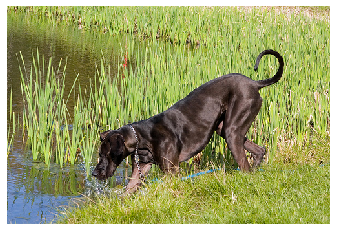

man in wetsuit is holding fishing pole


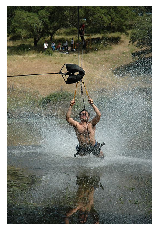

black dog runs on beach


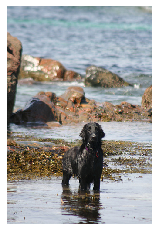

man in red shirt is standing in front of red and white landscape


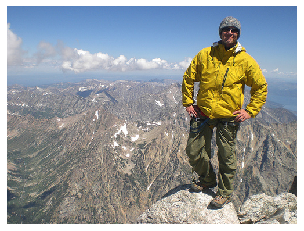

man in black shirt is jumping on the sidewalk


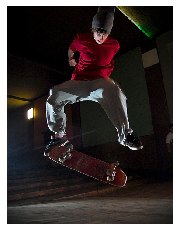

man in black shirt and white helmet is running


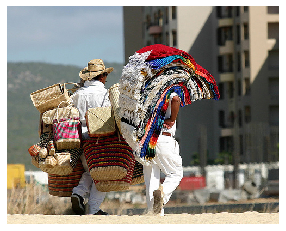

dog is running through the snow


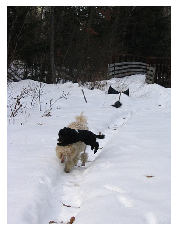

dog running through tall weeds


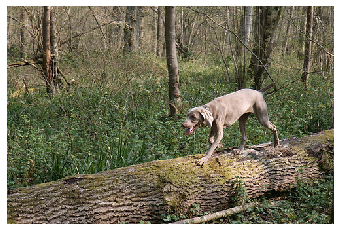

two hikers are walking through the snow


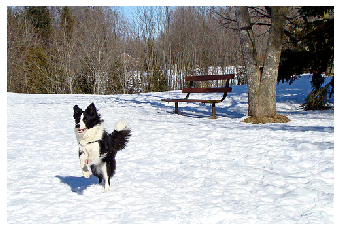

dog is growling up in the kitchen


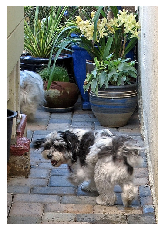

little girl in pink dress is blowing bubbles in front of her face


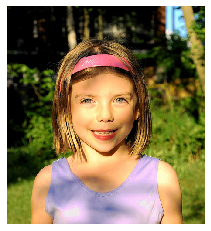

man on motorcycle is riding on dirt path


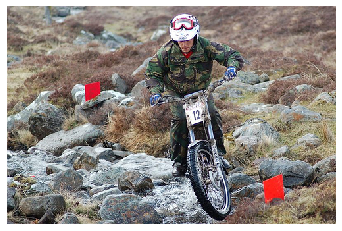

dog jumps over hurdle


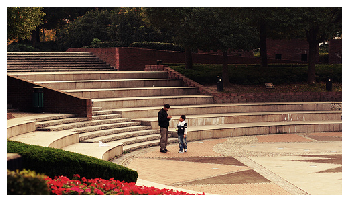

two teams players fighting for the ball


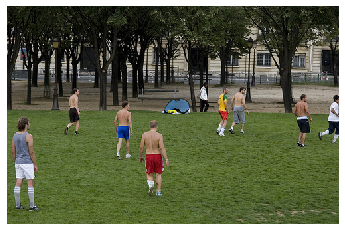

surfer surfs in the middle of wave


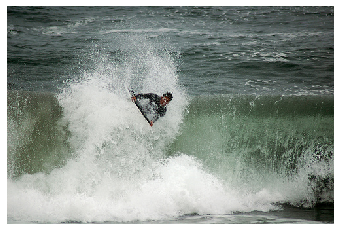

In [104]:
# picking some random images and getting the captions
for i in range(15):
    idx = np.random.randint(0,1000)
    all_image_name = list(encoding_test.keys())
    img_name = all_image_name[idx]
    photo2048 = encoding_test[img_name].reshape((1,2048))
    i = plt.imread(IMG_PATH + img_name + ".jpg")
    caption = predict_captions(photo2048)
    print(caption)
    plt.imshow(i)
    plt.axis('off')
    plt.show()